In [420]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

from tqdm import tqdm
from collections import Counter

import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
stopwords = English.Defaults.stop_words
nlp = English()
tokenizer = Tokenizer(nlp.vocab)

# Set device = CUDA if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [373]:
# Reading CSV File into Pandas DataFrame
df = pd.read_csv('Data/hw1_train-1.csv', index_col=0)
df.columns = ['text', 'labels']
df['labels'] = df['labels'].str.replace('none', '')
df['labels'] = df['labels'].fillna('')
print(df.size)

test_df = pd.read_csv('Data/hw1_test-2.csv', index_col=0)
test_df.columns = ['text']
print(test_df.size)

4624
981


In [374]:
# Splitting the dataset into the Training set and Validation set
train_data, val_data = train_test_split(df,
                                        random_state=0, 
                                        test_size=0.25, 
                                        shuffle=True)
print("Train Data: ")
print(train_data.head())
print("Val Data: ")
print(val_data.head())
print('Length -> Train Data: ' + str(len(train_data)))
print('Length -> Val Data: ' + str(len(val_data)))

Train Data: 
                                            text                        labels
ID                                                                            
909               can you show me movies spanish  movie.country movie.language
820                         in search for movies                              
1185  are there any g movies out there right now                  movie.rating
1971   show me more information about will smith                              
564                          who directed batman             movie.directed_by
Val Data: 
                                               text  \
ID                                                    
2154          show me the producer of the godfather   
563   can you tell me who is the director of batman   
789      get details of original finding nemo movie   
1325                             list french movies   
570    who directed the movie the thing called love   

                            labels  


In [375]:
# Create a set of Labels
label_set = set()
for index, row in df.iterrows():
    temp = row['labels'].split()
    for item in temp:
        label_set.add(item)      

label_list = np.reshape(np.array(list(label_set)), 
                            (-1, 1))
print(label_list)
# print(label_list.shape)    

[['movie.language']
 ['person.date_of_birth']
 ['movie.genre']
 ['gr.amount']
 ['movie.music']
 ['movie.starring.character']
 ['movie.directed_by']
 ['movie.locations']
 ['movie.produced_by']
 ['movie.production_companies']
 ['actor.gender']
 ['movie.subjects']
 ['movie.starring.actor']
 ['movie.rating']
 ['movie.gross_revenue']
 ['movie.estimated_budget']
 ['movie.country']
 ['movie.initial_release_date']]


In [376]:
# Fit Multi-Label Binarizer to Label List
mlb.fit(label_list)
# print(mlb.classes_)
# print(len(mlb.classes_))

# Enumerate classes for Labels        
id_to_label = {}
for idx, label in enumerate(mlb.classes_):
    id_to_label[idx] = label
print(id_to_label)  

{0: 'actor.gender', 1: 'gr.amount', 2: 'movie.country', 3: 'movie.directed_by', 4: 'movie.estimated_budget', 5: 'movie.genre', 6: 'movie.gross_revenue', 7: 'movie.initial_release_date', 8: 'movie.language', 9: 'movie.locations', 10: 'movie.music', 11: 'movie.produced_by', 12: 'movie.production_companies', 13: 'movie.rating', 14: 'movie.starring.actor', 15: 'movie.starring.character', 16: 'movie.subjects', 17: 'person.date_of_birth'}


In [377]:
# Fit Tf-Idf Vectorizer to training text
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2)

vectorizer.fit(train_data['text'])
print(vectorizer.get_feature_names_out())

def vectorize_to_tensor(text):
    text_list = []
    text_list.append(text)
    # Return tensor of encoded text using TF-IDF
    encoded = vectorizer.transform(text_list)
    encoded_tensor = torch.tensor(scipy.sparse.csr_matrix.todense(encoded)).float()
    return encoded_tensor

['1000' '1000 words' '13' ... 'zombie movies' 'zombies' 'zombies in']


In [379]:
# Relation Extraction Class for DataLoader
class RelationExtractionDataset(Dataset):
    
    def __init__(self, 
                 data: pd.DataFrame):
        self.data = data
        self.text = self.data['text']
        self.labels = self.data['labels']
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, 
                    idx: int):
        text = self.text.iloc[idx]
#         text = self.preprocess_text(self.text.iloc[idx])
        label = self.labels.iloc[idx].split()
        return self.encode_text(text), self.encode_label(label)

    def encode_text(self, 
                    text: str):
        return vectorize_to_tensor(text)
        
    def encode_label(self, 
                     label: str):
        # Convert label into NumPy matrix
        label_array = np.array(label)
        label_matrix = np.reshape(label_array, 
                                  (1, -1))
        # Return tensor of encoded label using Multi-Label Binarizer
        encoded = mlb.transform(label_matrix)
        encoded_label = torch.from_numpy(encoded)
        return encoded_label
         
    def tokenize(self, 
                 text: str):
        return [i.text for i in tokenizer(text)]

    def stopword_removal(self,
                         text: str):
        corpus = []
        for item in self.tokenize(text):
            if item not in stopwords:
                corpus.append(item)
        corpus = ' '.join(corpus)          
        return corpus

    def preprocess_text(self, 
                        text: str):
        # Convert text to lowercase
        text = text.lower()
        # Removing text contractions
        text = re.sub(r"there's", "there is", text)
        text = re.sub(r"that's", "that is", text)
        text = re.sub(r"she's", "she is", text)
        text = re.sub(r"he's", "he is", text)
        text = re.sub(r"what's", "what is", text)
        text = re.sub(r"where's", "where is", text)
        text = re.sub(r"who's", "who is", text)
        text = re.sub(r"you're", "you are", text)
        text = re.sub(r"i'm", "i am", text)
        text = re.sub(r"i'd", "i would", text)
        text = re.sub(r"ain't", "am not", text)
        text = re.sub(r"don't", "donot", text)
        text = re.sub(r"can't", "cannot", text)
        text = re.sub(r"could't", "could not", text)
        text = re.sub(r"should'nt", "should not", text)
        text = re.sub(r"won't", "will not", text)
        # Removing all punctuation
        text = re.sub(r'[^\w\s]', '', text)
        # Removing links
        text = re.sub(r'http\S+', '', text)
        # Removing special characters and numbers
        text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
        # Removing single characters
        text = re.sub(r's+[a-zA-Z]s+', '', text)
        # Removing stopwords
        text = self.stopword_removal(text)
        # Replacing multi-spaces by a single space
        text = re.sub(r'\s+', ' ', text)
        return text

In [380]:
# Relation Extraction Object for DataLoader
train_ds = RelationExtractionDataset(train_data)
# train_ds[20]
val_ds = RelationExtractionDataset(val_data)
# print(val_ds[20])

In [381]:
# PyTorch Data Loader
train_loader = DataLoader(train_ds, 
                          batch_size=64, 
                          shuffle=True)
val_loader = DataLoader(val_ds, 
                        batch_size=1, 
                        shuffle=True)

In [382]:
# Multi-Layer Perceptron
class MLP(nn.Module):
    def __init__(
        self, 
        input_dim, 
        hidden_dim_1,
        hidden_dim_2,
        output_dim
    ):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, output_dim)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, 
                x):
        hidden1 = self.fc1(x)
        relu1 = self.relu(hidden1)
        hidden2 = self.fc2(relu1)
        relu2 = self.relu(hidden2)
        hidden3 = self.fc3(relu2)
        output = self.sigmoid(hidden3)
        return output

In [383]:
torch.manual_seed(32)
input_features_dim = train_ds[0][0].shape[1]
print(input_features_dim)
model = MLP(input_features_dim, 
            50, 
            50, 
            18).to(device)
print(model)

1576
MLP(
  (fc1): Linear(in_features=1576, out_features=50, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=18, bias=True)
  (sigmoid): Sigmoid()
)


In [384]:
# Model Train Function
def train(loader, 
          model, 
          optimizer, 
          loss_fn):
    model.train()
    losses = []
    pbar = tqdm(loader)
    for x, y in pbar:
        optimizer.zero_grad()
        
        y_pred = model(x)
        
        y = y.squeeze()
        y = y.to(torch.float32)
        
        y_pred = y_pred.squeeze()
        y_pred = y_pred.to(torch.float32)
        
        loss = loss_fn(y_pred, y)
        pbar.set_postfix({'Loss': loss.item()})
        losses.append(loss.item())
        
        # Calculate gradients for w/b
        loss.backward()  
        # Update weights according to optimizer rules
        optimizer.step()          
    return sum(losses) / len(losses)

# Model Evaluate Function
def evaluate(loader, 
             model, 
             loss_fn, 
             score_fn):
    model.eval()
    predictions = []
    labels = []
    for x, y in tqdm(loader):
        y_pred = model(x)
        y_pred = torch.round(y_pred)
        
        y = y.squeeze()
        y = y.to(torch.float32)
        
        y_pred = y_pred.squeeze()
        y_pred = y_pred.to(torch.float32)
        
        loss = loss_fn(y_pred, y)
        
        y = y.detach().numpy()
        y_pred = y_pred.detach().numpy()
        
        labels.append(y)
        predictions.append(y_pred)
    
    score = score_fn(labels, predictions, average='samples', zero_division=1)
    return labels, predictions, score

In [418]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# loss_fn = nn.BCEWithLogitsLoss()
loss_fn = nn.BCELoss()
score_fn = f1_score

n_epochs = 10
best_acc = 0
PATH = f'best-model.pt'
for epoch in range(n_epochs):
    avg_loss = train(train_loader, 
                     model, 
                     optimizer, 
                     loss_fn)
    print('Train Loss: ', avg_loss)
    
    labels, predictions, accuracy = evaluate(val_loader, 
                        model, 
                        loss_fn, 
                        score_fn)
    print('Val Accuracy: ', accuracy)
    
    if accuracy > best_acc and accuracy > 0.7:
        torch.save(model.state_dict(), PATH)
        cm = multilabel_confusion_matrix(labels, predictions)

100%|█████████████████████████████| 28/28 [00:00<00:00, 58.29it/s, Loss=3.26e-7]


Train Loss:  0.0025988301076245485


100%|███████████████████████████████████████| 578/578 [00:00<00:00, 2783.70it/s]


Val Accuracy:  0.777681660899654


100%|█████████████████████████████| 28/28 [00:00<00:00, 57.66it/s, Loss=2.61e-5]


Train Loss:  0.0027601457019435266


100%|███████████████████████████████████████| 578/578 [00:00<00:00, 2800.65it/s]


Val Accuracy:  0.8128604382929641


100%|██████████████████████████████| 28/28 [00:00<00:00, 58.08it/s, Loss=0.0348]


Train Loss:  0.002860112201233278


100%|███████████████████████████████████████| 578/578 [00:00<00:00, 2830.17it/s]


Val Accuracy:  0.7984429065743944


100%|█████████████████████████████| 28/28 [00:00<00:00, 59.54it/s, Loss=1.27e-7]


Train Loss:  0.0018853266041476096


100%|███████████████████████████████████████| 578/578 [00:00<00:00, 2774.77it/s]


Val Accuracy:  0.8031718569780854


100%|█████████████████████████████| 28/28 [00:00<00:00, 58.85it/s, Loss=0.00017]


Train Loss:  0.002122473937301298


100%|███████████████████████████████████████| 578/578 [00:00<00:00, 2771.04it/s]


Val Accuracy:  0.8117070357554786


100%|█████████████████████████████| 28/28 [00:00<00:00, 59.16it/s, Loss=5.63e-5]


Train Loss:  0.0013961837169387894


100%|███████████████████████████████████████| 578/578 [00:00<00:00, 2749.62it/s]


Val Accuracy:  0.7955594002306806


100%|█████████████████████████████| 28/28 [00:00<00:00, 59.16it/s, Loss=6.45e-6]


Train Loss:  0.001269437246126667


100%|███████████████████████████████████████| 578/578 [00:00<00:00, 2797.81it/s]


Val Accuracy:  0.8082468281430218


100%|██████████████████████████████| 28/28 [00:00<00:00, 59.45it/s, Loss=4.2e-6]


Train Loss:  0.0011745420146585925


100%|███████████████████████████████████████| 578/578 [00:00<00:00, 2896.88it/s]


Val Accuracy:  0.8042099192618224


100%|█████████████████████████████| 28/28 [00:00<00:00, 59.05it/s, Loss=1.05e-5]


Train Loss:  0.0011096057177642901


100%|███████████████████████████████████████| 578/578 [00:00<00:00, 2697.58it/s]


Val Accuracy:  0.8001730103806228


100%|█████████████████████████████| 28/28 [00:00<00:00, 58.52it/s, Loss=4.36e-6]


Train Loss:  0.0011813429068589748


100%|███████████████████████████████████████| 578/578 [00:00<00:00, 2771.63it/s]

Val Accuracy:  0.8088235294117647


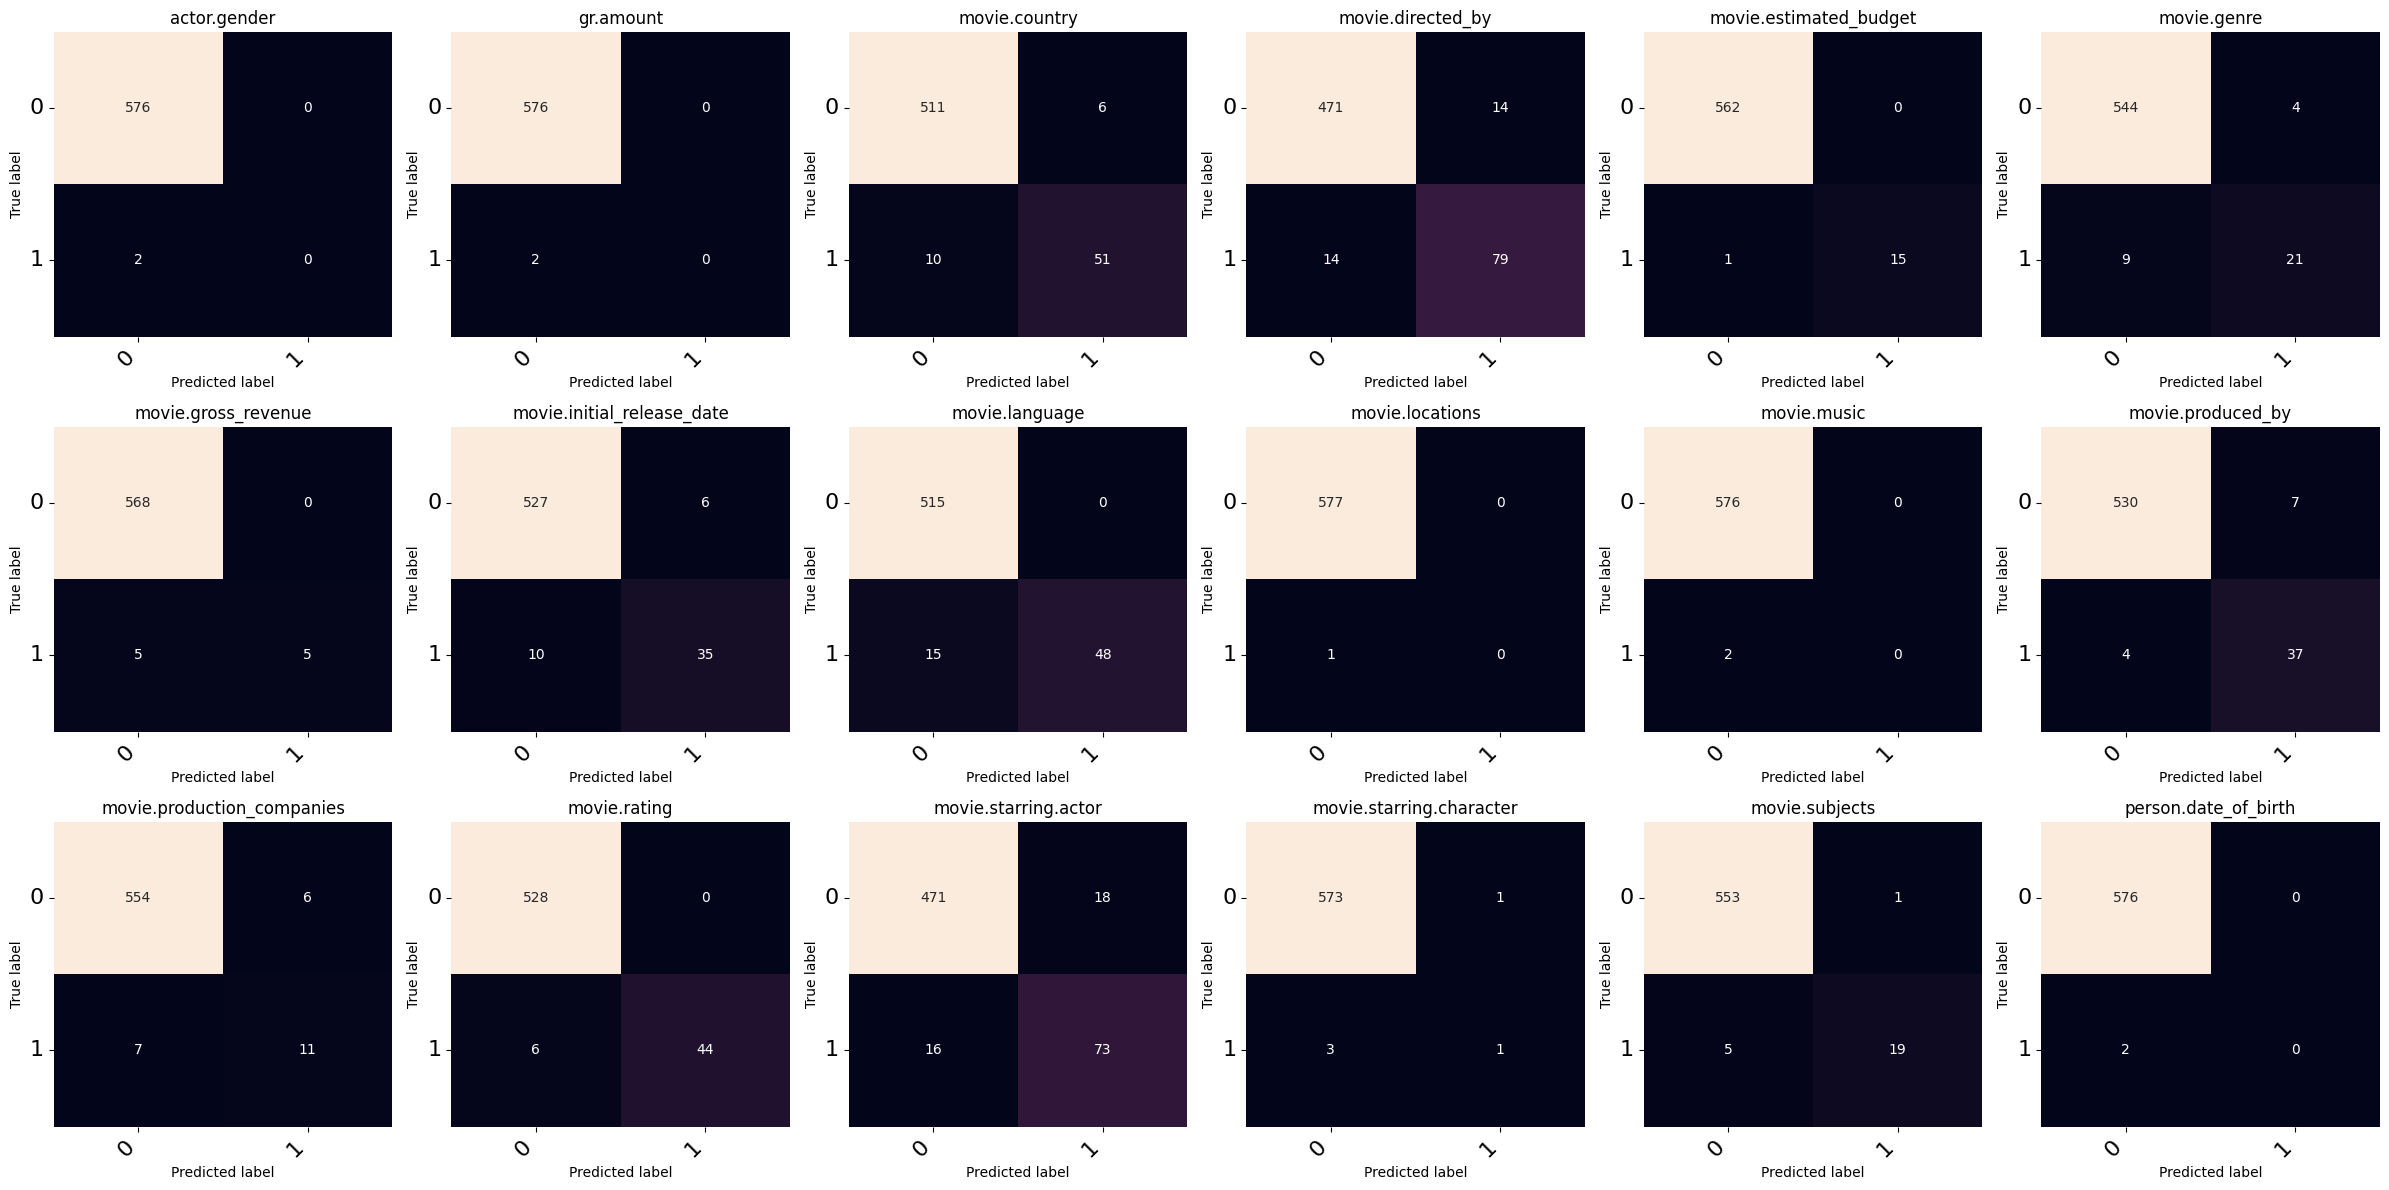

In [430]:
# Confusion Matrix for 18 Classes
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=16):
    df_cm = pd.DataFrame(confusion_matrix, 
                         index=class_names, 
                         columns=class_names)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(class_label)

cm_labels = []    
for key, value in id_to_label.items():
    cm_labels.append(value)     
    
fig, ax = plt.subplots(3, 6, figsize=(24, 12))
    
for axes, cfs_matrix, label in zip(ax.flatten(), cm, cm_labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])

fig.tight_layout()
plt.show()    

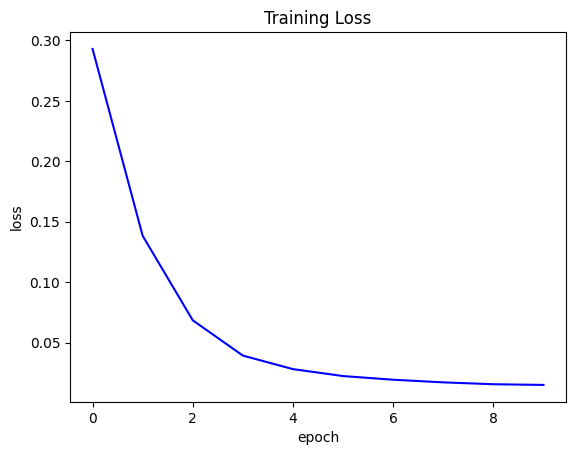

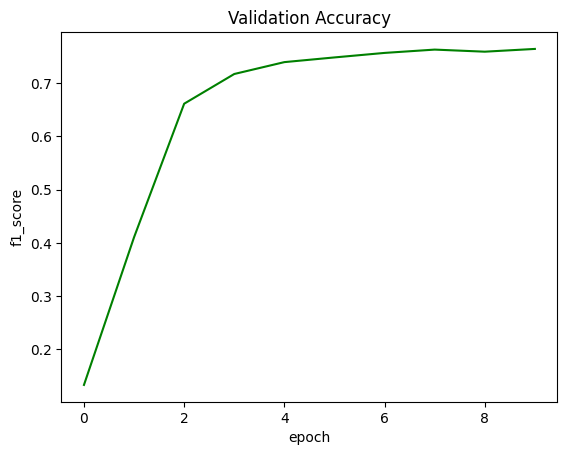

In [355]:
def x_vs_y_plot(x_list, 
                y_list, 
                x_label, 
                y_label, 
                plt_title, 
                color='blue'):
    plt.plot(x_list,
             y_list, color)
    plt.title(plt_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)   
    plt.show()   

epochs = np.arange(0, n_epochs)    
# Plot Training Loss
x_vs_y_plot(epochs, avg_loss_list, 'epoch', 'loss', 'Training Loss')  

# Plot Validation Accuracy
x_vs_y_plot(epochs, f1_score_list, 'epoch', 'f1_score', 'Validation Accuracy', 'green')  

In [253]:
# Save and Load the Model
saved_model = MLP(input_features_dim, 
            50, 
            18).to(device)
saved_model.load_state_dict(torch.load(PATH))
saved_model.eval()

MLP(
  (fc1): Linear(in_features=1576, out_features=50, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=50, out_features=18, bias=True)
  (sigmoid): Sigmoid()
)

In [254]:
# Use Saved Model for Predictions
label_tensors = []
label_id = []
with torch.no_grad():
    for index, row in test_df.iterrows():
        text_tensor = vectorize_to_tensor(row.to_string())
        label_tensor = model.forward(text_tensor)
        label_tensor = torch.sigmoid(label_tensor)
        label_tensor_round = torch.round(label_tensor)
        print(label_tensor_round)
        label_tensors.append(label_tensor_round)
        label_id.append(mlb.inverse_transform(label_tensor_round))

# print(label_tensors)
# print(label_id)

label_list = []
for i in range (0, len(label_id)):
    labels = list(label_id[i][0])
    label_list.append(labels)

# print(label_list)

# Creating Dictionary
list_of_dict = []

for i in range(0, len(label_list)):
    temp_dict = {}
    temp_dict["ID"] = i
    temp_dict["UTTERANCES"] = ' '.join(label_list[i])
    list_of_dict.append(temp_dict)

# print(list_of_dict)

labels_df = pd.DataFrame.from_dict(list_of_dict)
labels_df.to_csv('submission.csv.zip', compression='zip', index=False)
print(labels_df)

tensor([[1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.]])
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.]])
tens

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])
tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])
tensor([[0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])
tens

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.]])
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])
tensor([[0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([[0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.]])
tensor([[0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tens